In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline

In [ ]:
def centroid(img, lcc=False):
  if lcc:
    img = img.astype(np.uint8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=4)
    sizes = stats[:, -1]
    if len(sizes) > 2:
      max_label = 1
      max_size = sizes[1]

      for i in range(2, nb_components):
          if sizes[i] > max_size:
              max_label = i
              max_size = sizes[i]

      img2 = np.zeros(output.shape)
      img2[output == max_label] = 255
      img = img2

  if len(img.shape) > 2:
    M = cv2.moments(img[:,:,1])
  else:
    M = cv2.moments(img)

  if M["m00"] == 0:
    return (img.shape[0] // 2, img.shape[1] // 2)
  
  cX = int(M["m10"] / M["m00"])
  cY = int(M["m01"] / M["m00"])
  return (cX, cY)

def to_polar(input_img, center):
  #input_img = input_img.astype(np.float32)
  value = np.sqrt(((input_img.shape[0]/2.0)**2.0)+((input_img.shape[1]/2.0)**2.0))
  polar_image = cv2.linearPolar(input_img, center, value, cv2.WARP_FILL_OUTLIERS)
  polar_image = cv2.rotate(polar_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
  return polar_image

def to_cart(input_img, center):
  input_img = input_img.astype(np.float32)
  input_img = cv2.rotate(input_img, cv2.ROTATE_90_CLOCKWISE)
  value = np.sqrt(((input_img.shape[1]/2.0)**2.0)+((input_img.shape[0]/2.0)**2.0))
  polar_image = cv2.linearPolar(input_img, center, value, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)
  polar_image = polar_image.astype(np.uint8)
  return polar_image

In [ ]:
#Create paths for tumor segmentation
tumor_seg = '/content/drive/MyDrive/Thesis/train_polar_tumor'
train_tumor_seg = os.path.join(tumor_seg, 'train')
os.mkdir(train_tumor_seg)
valid_tumor_seg = os.path.join(tumor_seg, 'valid')
os.mkdir(valid_tumor_seg)
train_CT_images = os.path.join(train_tumor_seg, 'CT_images')
os.mkdir(train_CT_images)
train_ct_images = os.path.join(train_CT_images, 'ct_images')
os.mkdir(train_ct_images)
train_Tumor_masks = os.path.join(train_tumor_seg, 'Tumor_masks')
os.mkdir(train_Tumor_masks)
train_tumor_masks = os.path.join(train_Tumor_masks, 'tumor_masks')
os.mkdir(train_tumor_masks)
valid_CT_images = os.path.join(valid_tumor_seg, 'CT_images')
os.mkdir(valid_CT_images)
valid_ct_images = os.path.join(valid_CT_images, 'ct_images')
os.mkdir(valid_ct_images)
valid_Tumor_masks = os.path.join(valid_tumor_seg, 'Tumor_masks')
os.mkdir(valid_Tumor_masks)
valid_tumor_masks = os.path.join(valid_Tumor_masks, 'tumor_masks')
os.mkdir(valid_tumor_masks)

In [ ]:
train_ct_path = os.path.join('/content/drive/MyDrive/Thesis/train_tumor_seg/train/CT_images/ct_images')
valid_ct_path = os.path.join('/content/drive/MyDrive/Thesis/train_tumor_seg/valid/CT_images/ct_images')
train_tumor_path = os.path.join('/content/drive/MyDrive/Thesis/train_tumor_seg/train/Tumor_masks/tumor_masks')
valid_tumor_path = os.path.join('/content/drive/MyDrive/Thesis/train_tumor_seg/valid/Tumor_masks/tumor_masks')

In [ ]:
train_filenames = os.listdir(train_tumor_path)

for filename in train_filenames:
    mask = cv2.imread(os.path.join(train_tumor_path, filename), cv2.IMREAD_GRAYSCALE)
    if mask.sum() != 0:
      image = cv2.imread(os.path.join(train_ct_path, filename.replace('segmentation', 'volume')))
      center = centroid(mask)
      if np.random.uniform() < 0.3:
        center_max_shift = 0.05 * mask.shape[0]
        center = np.array(center)
        center = (center[0] + np.random.uniform(-center_max_shift, center_max_shift),
                center[1] + np.random.uniform(-center_max_shift, center_max_shift))

      image = to_polar(image, center)
      mask = to_polar(mask, center)
      cv2.imwrite(os.path.join(train_ct_images, filename.replace('segmentation', 'volume')), image)
      cv2.imwrite(os.path.join(train_tumor_masks, filename), mask)

In [ ]:
valid_filenames = os.listdir(valid_tumor_path)

for filename in valid_filenames:
    mask = cv2.imread(os.path.join(valid_tumor_path, filename), cv2.IMREAD_GRAYSCALE)
    if mask.sum() != 0:
      image = cv2.imread(os.path.join(valid_ct_path, filename.replace('segmentation', 'volume')))
      center = centroid(mask)
      if np.random.uniform() < 0.3:
        center_max_shift = 0.05 * mask.shape[0]
        center = np.array(center)
        center = (center[0] + np.random.uniform(-center_max_shift, center_max_shift),
                center[1] + np.random.uniform(-center_max_shift, center_max_shift))

      image = to_polar(image, center)
      mask = to_polar(mask, center)
      cv2.imwrite(os.path.join(valid_ct_images, filename.replace('segmentation', 'volume')), image)
      cv2.imwrite(os.path.join(valid_tumor_masks, filename), mask)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import image
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax
from tensorflow.keras.activations import sigmoid

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from cv2 import imread, createCLAHE 
from glob import glob

from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import *
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import layers

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
def iou_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (keras.sum(y_true_f) + keras.sum(y_pred_f) - intersection + 1.0)

In [ ]:
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model


input_shape = (512, 512, 3)
model = build_resnet50_unet(input_shape)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

In [ ]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = (img - img.min()) / (img.max() - img.min())
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = (img - img.min()) / (img.max() - img.min())
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img, mask)

def trainGenerator(batch_size,train_path,image_folder,
                   mask_folder,
                   aug_dict,
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale",
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   flag_multi_class = False,
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (256,256),
                   seed = 1,
                   subset = 'training'):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed,
        subset = subset)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed,
        subset = subset)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest',
                    validation_split=0)


train_generator = trainGenerator(8,'/content/drive/MyDrive/Thesis/train_polar_tumor/train','CT_images','Tumor_masks',data_gen_args,save_to_dir = None,
                                target_size = (512, 512))
valid_generator = trainGenerator(8,'/content/drive/MyDrive/Thesis/train_polar_tumor/valid','CT_images','Tumor_masks',data_gen_args,save_to_dir = None,
                                target_size = (512, 512))

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

Found 4645 images belonging to 1 classes.
Found 4645 images belonging to 1 classes.


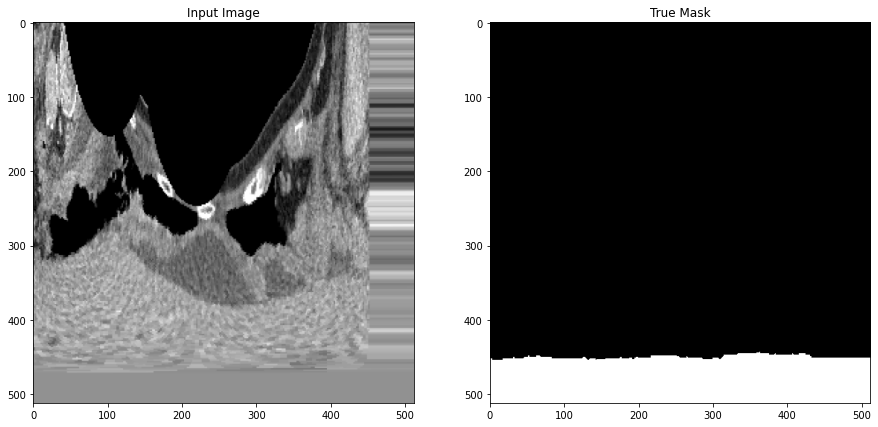

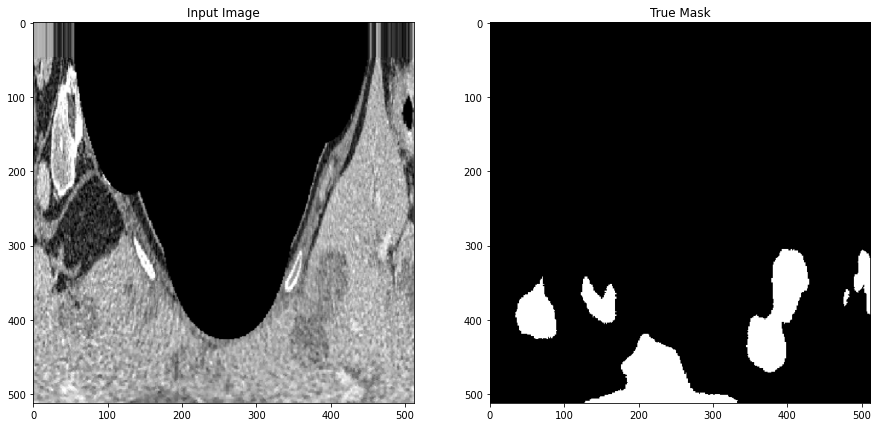

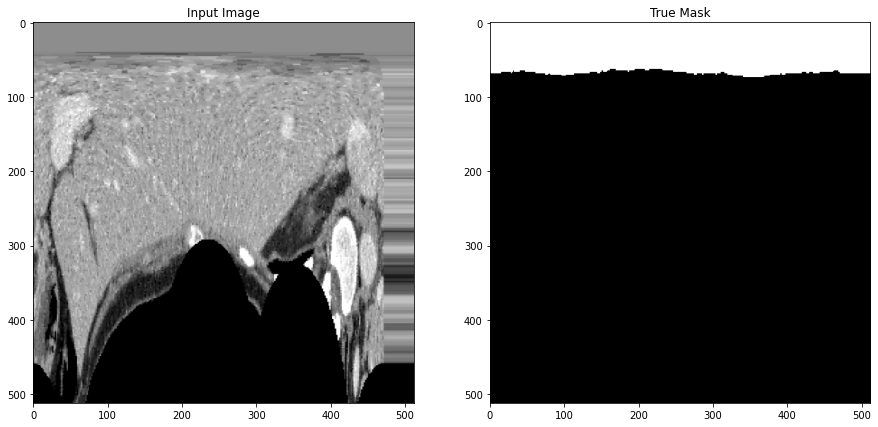

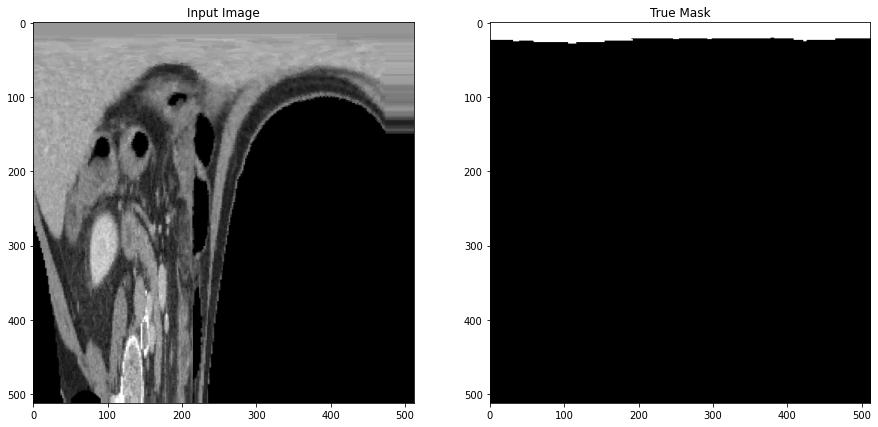

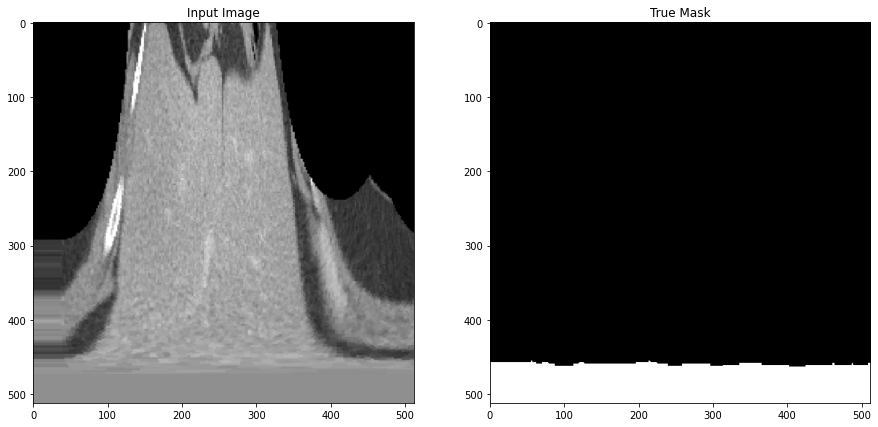

In [ ]:
show_dataset(train_generator, 5)

Found 1242 images belonging to 1 classes.
Found 1242 images belonging to 1 classes.


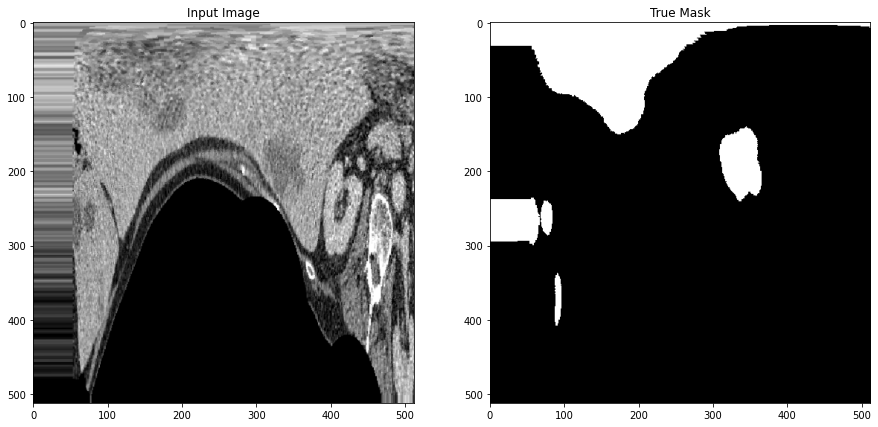

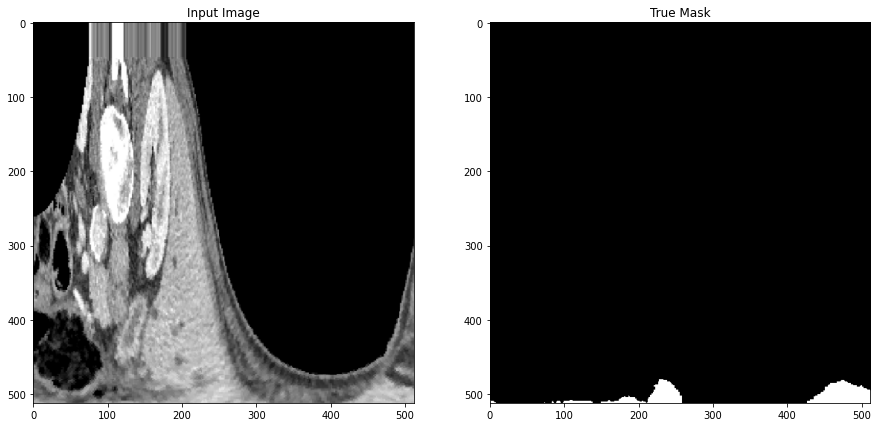

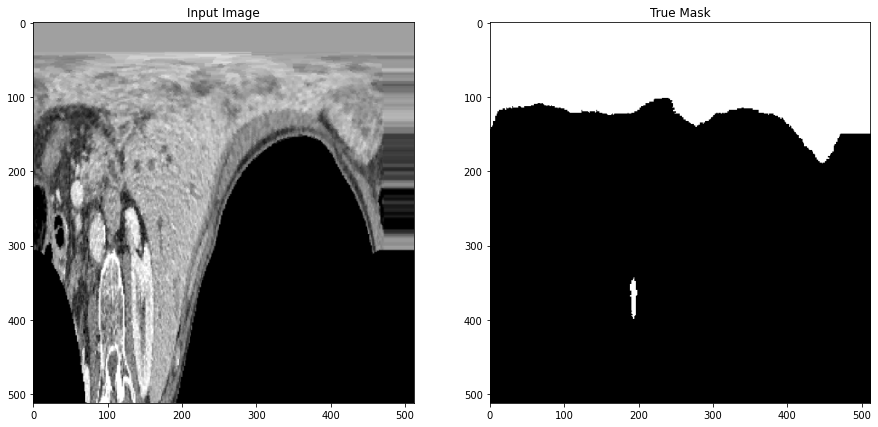

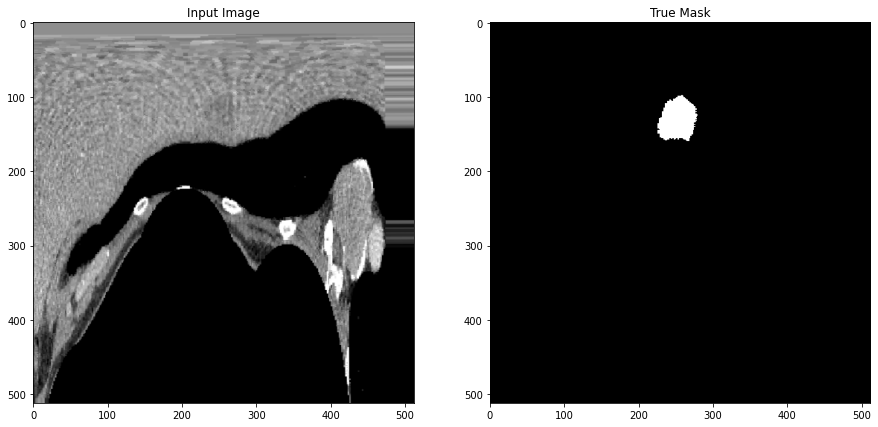

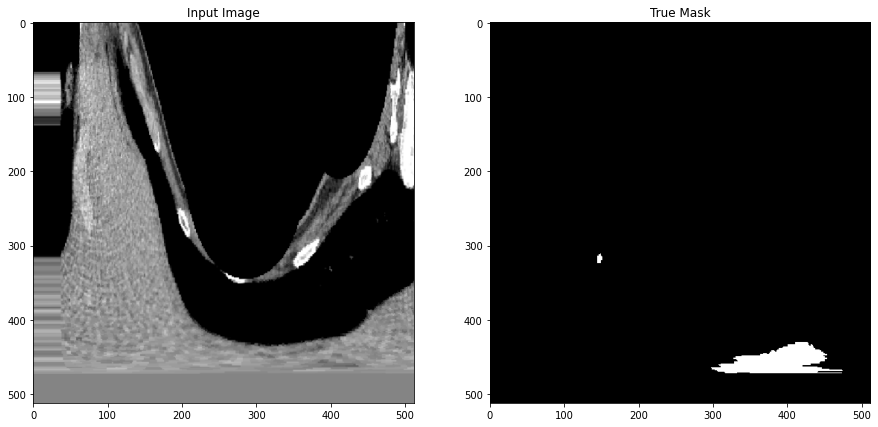

In [ ]:
show_dataset(valid_generator, 5)

In [ ]:
model.load_weights('/content/drive/MyDrive/Thesis/weights/tumor-liver-crops-512x512_weights_best.hdf5')

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, iou_coef])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="/content/drive/MyDrive/Thesis/weights/{}_weights_best.hdf5".format('tumor-liver-crops-polar-512x512')

model_checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

model_tensorboard = TensorBoard('./', write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-08)
model_earlystop = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited

model_callbacks = [model_checkpoint,
                   model_tensorboard,
                   reduce_lr,
                   model_earlystop]

In [ ]:
num_train = 4645
num_valid = 1242

train_batchsize = 8
valid_batchsize = 8

Step_train = num_train // train_batchsize
Step_valid = num_valid // valid_batchsize
epochs = 100

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=Step_train,
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=Step_valid,
                    verbose=1,
                    callbacks=model_callbacks)

Epoch 1/100
580/580 [==============================] - ETA: 0s - loss: 0.2306 - dice_coef: 0.7695 - iou_coef: 0.6403
Epoch 1: val_dice_coef improved from -inf to 0.74229, saving model to /content/drive/MyDrive/Thesis/weights/tumor-liver-crops-polar-512x512_weights_best.hdf5
580/580 [==============================] - 516s 881ms/step - loss: 0.2306 - dice_coef: 0.7695 - iou_coef: 0.6403 - val_loss: 0.2576 - val_dice_coef: 0.7423 - val_iou_coef: 0.5975 - lr: 1.0000e-05
Epoch 2/100
580/580 [==============================] - ETA: 0s - loss: 0.1877 - dice_coef: 0.8123 - iou_coef: 0.6942
Epoch 2: val_dice_coef did not improve from 0.74229
580/580 [==============================] - 500s 863ms/step - loss: 0.1877 - dice_coef: 0.8123 - iou_coef: 0.6942 - val_loss: 0.2690 - val_dice_coef: 0.7320 - val_iou_coef: 0.5850 - lr: 1.0000e-05
Epoch 3/100
580/580 [==============================] - ETA: 0s - loss: 0.1761 - dice_coef: 0.8239 - iou_coef: 0.7086
Epoch 3: val_dice_coef did not improve from 0.7

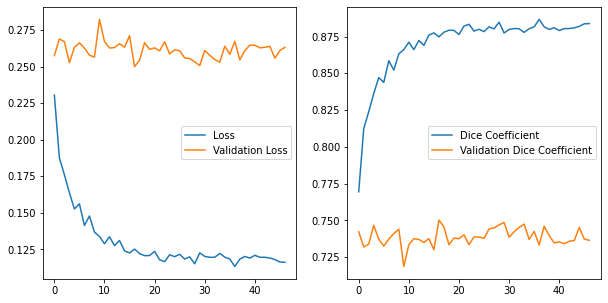

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(np.array(history.history['dice_coef']), '-', 
         label = 'Dice Coefficient')
ax2.plot(np.array(history.history['val_dice_coef']), '-',
         label = 'Validation Dice Coefficient')
ax2.legend()